In [2]:
from nltk import accuracy
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [3]:
X, y = mnist['data'], mnist['target']

In [4]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [5]:
X.shape, y.shape

((70000, 784), (70000,))

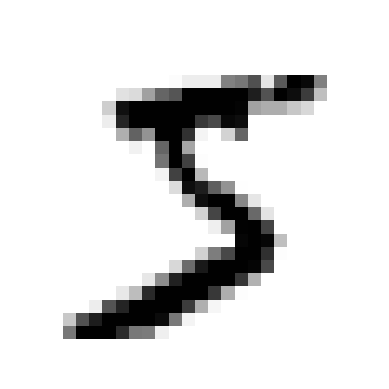

In [6]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    plt.show()

plot_digit(X[0])

In [7]:
y[0]

'5'

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [10]:
y_train_5

array([ True, False, False, ...,  True, False, False])

In [11]:
y_train_5.shape, y_test_5.shape

((60000,), (10000,))

In [12]:
from sklearn.linear_model import SGDClassifier
sgd_cls = SGDClassifier()
sgd_cls.fit(X_train, y_train_5)

SGDClassifier()

In [13]:
sgd_cls.predict([X[0]])

array([False])

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_cls, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91985, 0.96375, 0.9667 ])

In [15]:
from sklearn.dummy import DummyClassifier
dummy_cls = DummyClassifier()
dummy_cls.fit(X_train, y_train_5)

DummyClassifier()

In [16]:
print(any(dummy_cls.predict(X_train)))

False


In [17]:
cross_val_score(dummy_cls, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

In [18]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_cls, X_train, y_train_5, cv=3)

In [19]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53896,   683],
       [ 1558,  3863]], dtype=int64)

In [20]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)

precision, recall

(0.8497580290365156, 0.7125991514480723)

In [21]:
from sklearn.metrics import f1_score

f1 = f1_score(y_train_5, y_train_pred)
f1

0.7751580214708538

In [22]:
decision_scores = sgd_cls.decision_function([X_train[0]])
decision_scores

array([-2214.05577323])

In [23]:
y_scores = cross_val_predict(sgd_cls, X_train, y_train_5, cv=3, method='decision_function')

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

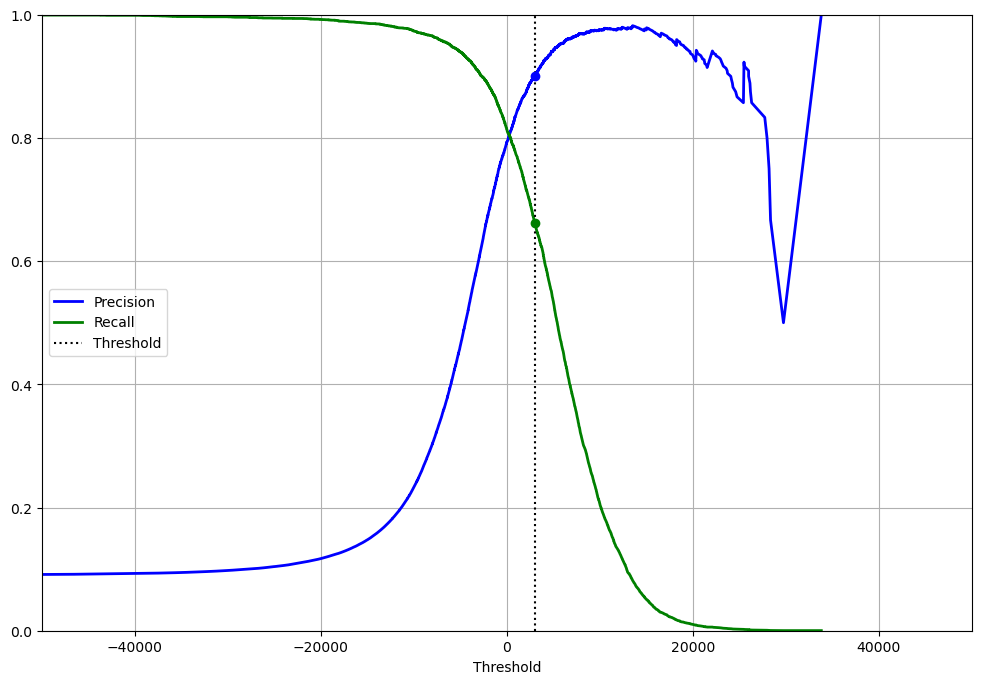

In [25]:
threshold = 3000
plt.figure(figsize=(12, 8))
plt.plot(thresholds, precisions[:-1], "b-", label='Precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label='Recall', linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label='Threshold')
idx = (thresholds >= threshold).argmax()
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid(True)
plt.xlabel('Threshold')
plt.legend(loc="center left")
plt.show()

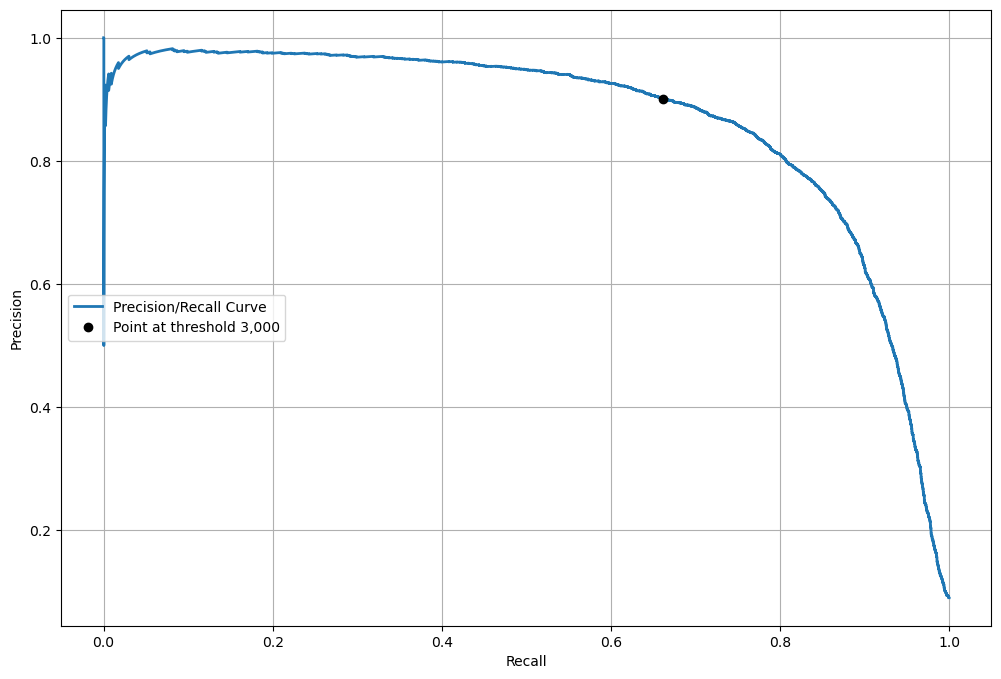

In [26]:
plt.figure(figsize=(12, 8))
plt.plot(recalls, precisions, linewidth=2, label='Precision/Recall Curve')
plt.plot([recalls[idx]], [precisions[idx]], "ko", label="Point at threshold 3,000")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.legend(loc="center left")
plt.show()

In [27]:
idx_for_90_precision = (precisions >= 0.9).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

2959.7782817358684

In [28]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [29]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

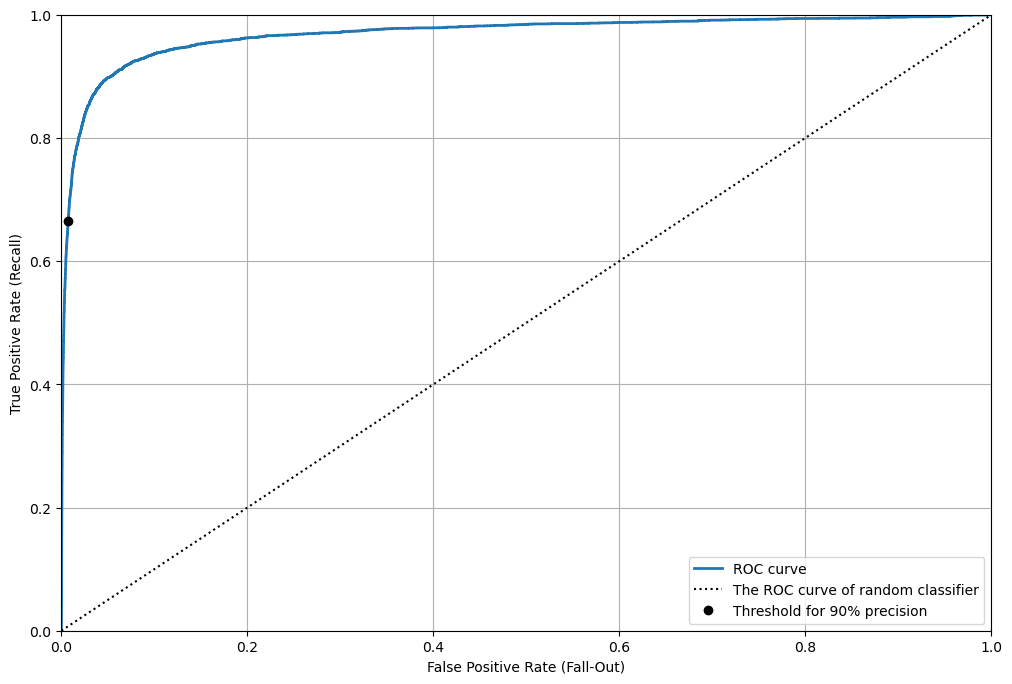

In [30]:
plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, linewidth=2, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k:', label='The ROC curve of random classifier')
plt.plot([fpr_90], [tpr_90], 'ko', label='Threshold for 90% precision')
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right")

In [31]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9688030421212249

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest_cls = RandomForestClassifier(random_state=42)

In [33]:
y_probas_forest = cross_val_predict(forest_cls, X_train, y_train_5, cv=3, method='predict_proba')

In [34]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [35]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

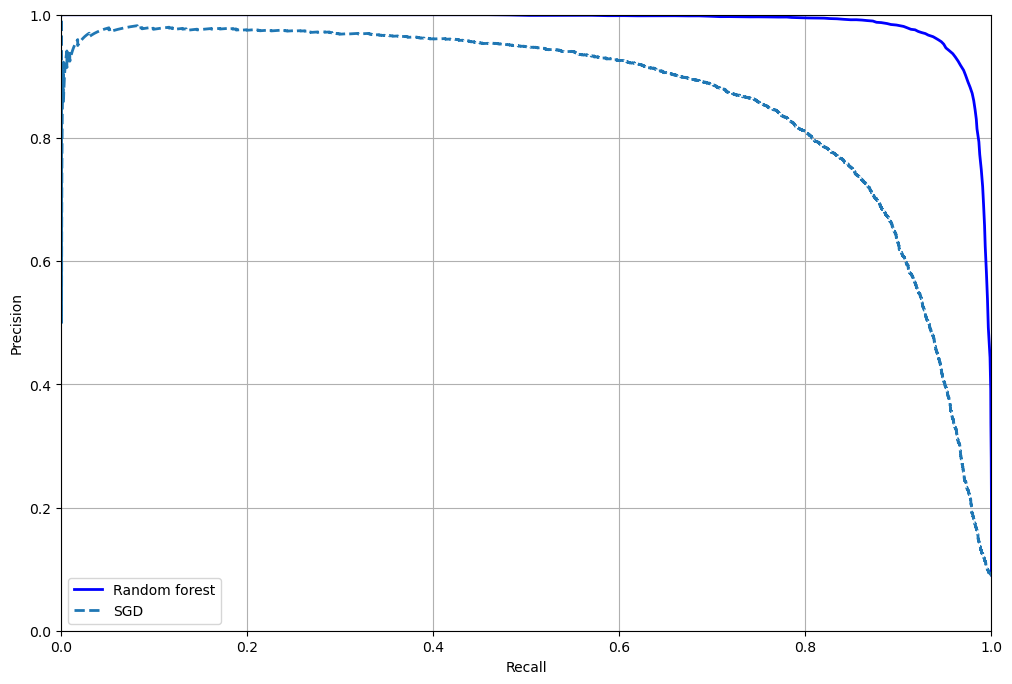

In [36]:
plt.figure(figsize=(12, 8))
plt.plot(recalls_forest, precisions_forest, 'b-', linewidth=2, label='Random forest')
plt.plot(recalls, precisions, '--', linewidth=2, label='SGD')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.legend(loc="lower left")
plt.show()

In [37]:
y_train_pred_forest = (y_scores_forest >= 0.5)
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [38]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [39]:
from sklearn.svm import SVC

svm_cls = SVC(random_state=42)
svm_cls.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [40]:
svm_cls.predict([X_train[0]])

array(['5'], dtype=object)

In [41]:
from sklearn.multiclass import OneVsRestClassifier

ovr_cls = OneVsRestClassifier(SVC(random_state=42))
ovr_cls.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [42]:
ovr_cls.predict([X_train[0]])

array(['5'], dtype='<U1')

In [43]:
sgd_cls = SGDClassifier(random_state=42)
sgd_cls.fit(X_train, y_train)
sgd_cls.predict([X_train[0]])

array(['3'], dtype='<U1')

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
param_grid = [{'n_neighbors': [3, 4, 5, 6],
               'weights': ['uniform', 'distance']}]
knn_clf = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
knn_clf.fit(X_train_scaled[:10000], y_train[:10000])

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}],
             scoring='accuracy')

In [53]:
print(f"Grid best params: {knn_clf.best_params_}")

Grid best params: {'n_neighbors': 4, 'weights': 'distance'}


In [54]:
print(f"Grid best score: {knn_clf.best_score_}")

Grid best score: 0.9096


In [55]:
knn_clf.fit(X_train[:10000], y_train[:10000])

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}],
             scoring='accuracy')

In [56]:
knn_clf.best_score_

0.9441999999999998

In [57]:
knn_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}],
             scoring='accuracy')

In [58]:
from sklearn.metrics import accuracy_score

y_pred = knn_clf.predict(X_test)
print(f"Accuracy for test set: {accuracy_score(y_test, y_pred)}")

Accuracy for test set: 0.9714


In [63]:
from scipy.ndimage import shift

def shift_image(image, dx, dy):
    image = image.reshape(28, 28)
    shifted_image = shift(image, (dx, dy))
    return shifted_image.reshape([-1])

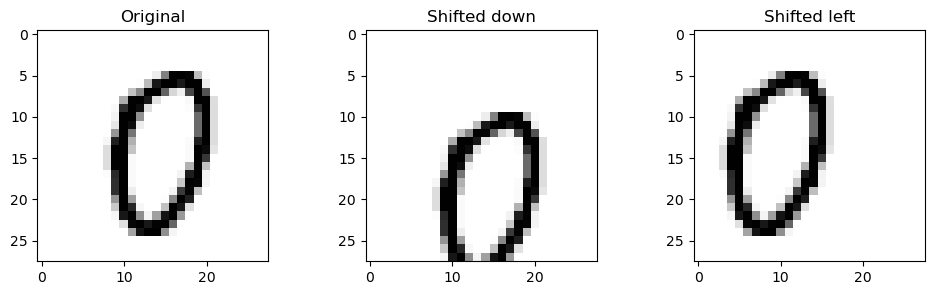

In [65]:
image = X_train[1000]
shifted_image_down = shift_image(image, 5, 0)
shifted_image_left = shift_image(image, 0, -5)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original")
plt.imshow(image.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down")
plt.imshow(shifted_image_down.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left")
plt.imshow(shifted_image_left.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.show()

In [66]:
type(shifted_image_down)

numpy.ndarray

In [69]:
import numpy as np

X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (0, -1), (1, 0), (0, 1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [72]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [73]:
knn_clf = KNeighborsClassifier(**knn_clf.best_params_)
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [74]:
knn_clf.score(X_test, y_test)

0.9763